In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import warnings
import mne
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

In [7]:
data_path = 'dataset'
channelposition_path = 'newspline62_cl.locs'
montage=mne.channels.read_custom_montage(channelposition_path)
info = mne.create_info(ch_names=montage.ch_names, sfreq=1000,ch_types='eeg')
channels = 62
features = 5

In [8]:
subjects = os.listdir(data_path)
pos, neg = [], []
for person in subjects:
    perpath = os.path.join(data_path, person)
    data_list = os.listdir(perpath)
    data = np.load(os.path.join(perpath, data_list[0]))
    for i in range(1, len(data_list)):
        data = np.concatenate((data, np.load(os.path.join(perpath, data_list[i]))), axis=0)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data, label = data[:,:-1], data[:,-1]
    data = scaler.fit_transform(data)
    pos_data, neg_data = np.mean(data[label==1],axis=0), np.mean(data[label==0],axis=0)
    pos.append(pos_data)
    neg.append(neg_data)
pos, neg = np.mean(np.array(pos),axis=0).reshape(channels,features).T, np.mean(np.array(neg),axis=0).reshape(channels,features).T
# pos, neg = np.mean(np.array(pos),axis=0).reshape(features,channels), np.mean(np.array(neg),axis=0).reshape(features,channels)
vmin = min(np.min(pos), np.min(neg))
vmax = max(np.max(pos), np.max(neg))
print(vmin,vmax)

0.2736044277654216 0.6856382009487868


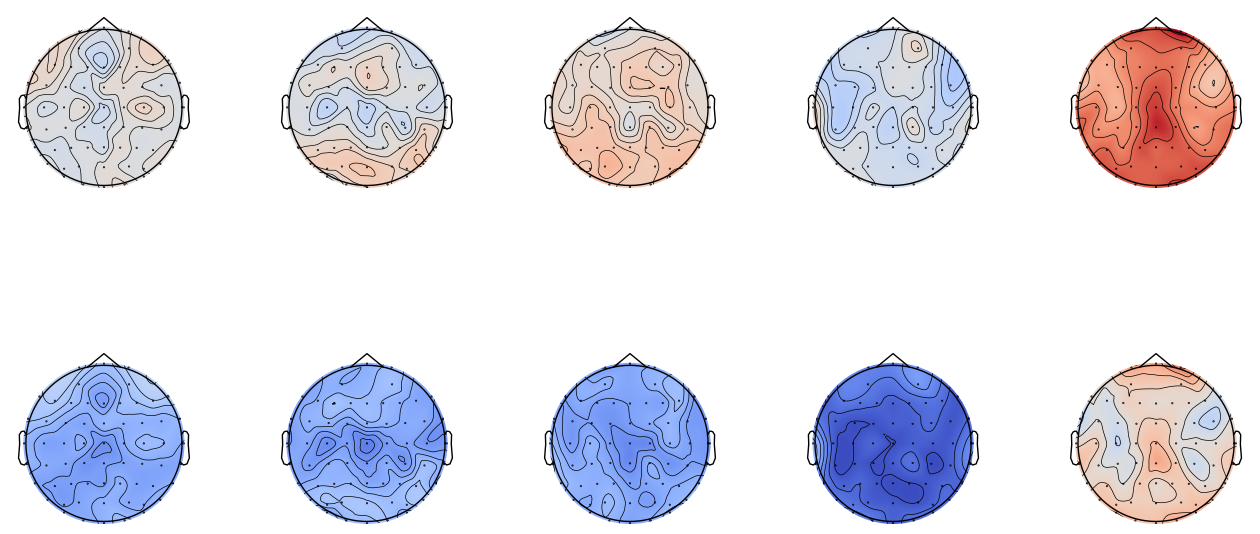

In [9]:
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
subplots = []
for i in range(features):
    band1 = pos[i].reshape(channels, 1) # (62,1)
    evoked1 = mne.EvokedArray(band1, info)
    evoked1.set_montage(montage)
    subplots.append(evoked1)
for i in range(features):
    band2 = neg[i].reshape(channels, 1) # (62,1)
    evoked2 = mne.EvokedArray(band2, info)
    evoked2.set_montage(montage)
    subplots.append(evoked2)
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    mne.viz.plot_topomap(subplots[i].data[:,0], subplots[i].info, ch_type='eeg',cmap='coolwarm', axes=ax, show=False,vlim=(vmin,vmax))
# cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # 调整颜色条的位置
# cbar = fig.colorbar(ax.collections[0], cax=cbar_ax, orientation='vertical', ticks=[vmin, vmax], cmap='seismic',norm = norm)
# cbar.set_label('Colorbar Label')  # 标签可以根据需要进行修改
# # 调整子图之间的间距
fig.subplots_adjust(wspace=0.4)
# 显示图形
fig.show()